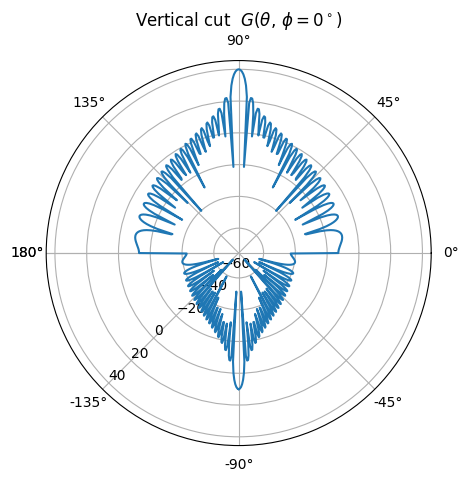

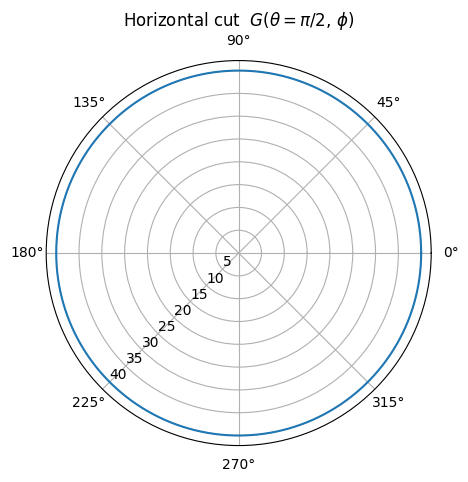

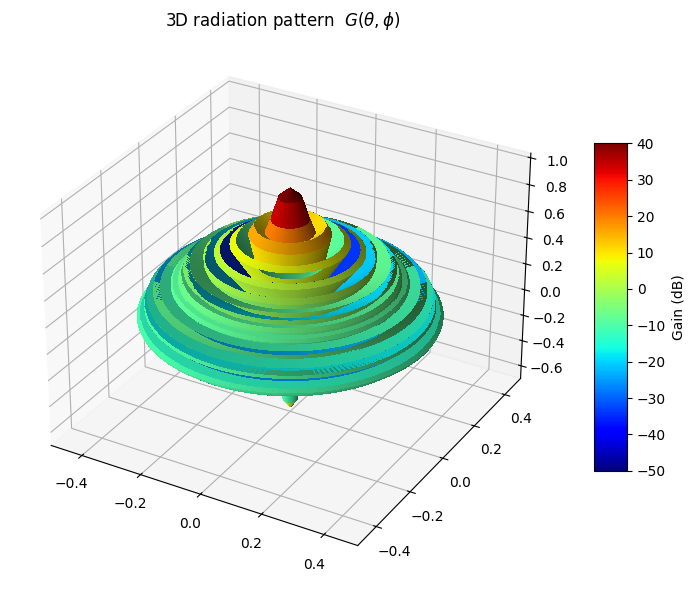

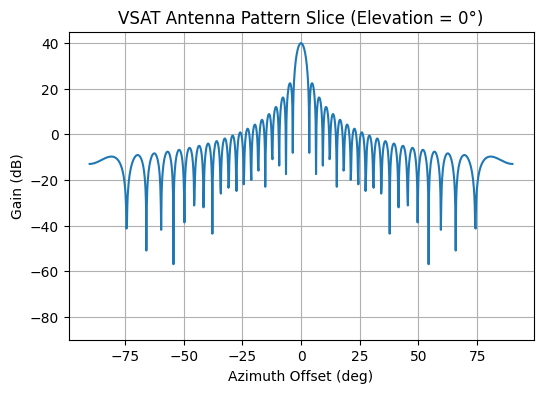

In [1]:
import numpy as np
from scipy.special import j1
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


class DishAntenna3DPattern:
    def __init__(self, frequency_hz: float,
                 aperture_radius_lambda: float = 10,
                 tx_gain_dB: float = 0.0):
        """
        Parameters
        ----------
        frequency_hz : Carrier frequency (Hz)
        aperture_radius_lambda : Aperture radius (in wavelengths)
        tx_gain_dB : Peak gain (dBi)
        """
        c = 3e8
        self.f = frequency_hz
        self.lambda_ = c / frequency_hz
        self.a = aperture_radius_lambda * self.lambda_
        self.max_gain_linear = 10 ** (tx_gain_dB / 10)

    @staticmethod
    def sph2cart(azimuth_deg, elevation_deg):
        """Convert azimuth/elevation [deg] to 3D unit vector"""
        az = np.radians(azimuth_deg)
        el = np.radians(elevation_deg)
        x = np.cos(el) * np.cos(az)
        y = np.cos(el) * np.sin(az)
        z = np.sin(el)
        return np.stack([x, y, z], axis=-1)

    def gain_linear(self,
                    ray_azimuth_deg, ray_elevation_deg,
                    azimuth_deg, elevation_deg):
        ray_vec = self.sph2cart(ray_azimuth_deg, ray_elevation_deg)
        aim_vec = self.sph2cart(azimuth_deg, elevation_deg)

        while aim_vec.ndim < ray_vec.ndim:
            aim_vec = aim_vec[np.newaxis, ...]

        alpha = np.arccos(np.clip(np.sum(ray_vec * aim_vec, axis=-1), -1.0, 1.0))
        u = 2.0 * np.pi * self.a * np.sin(alpha) / self.lambda_
        u_safe = np.where(np.abs(u) < 1e-10, 1e-10, u)
        pattern = (2.0 * j1(u_safe) / u_safe) ** 2
        pattern = np.where(np.abs(u) < 1e-10, 1.0, pattern)

        pattern = np.where(alpha > np.pi/2, pattern * 1e-3, pattern)
        return pattern * self.max_gain_linear

    def gain_db(self,
                ray_azimuth_deg, ray_elevation_deg,
                azimuth_deg, elevation_deg):
        g_lin = self.gain_linear(ray_azimuth_deg, ray_elevation_deg,
                                 azimuth_deg, elevation_deg)
        return 10 * np.log10(np.maximum(g_lin, 1e-12))
def plot_antenna_pattern(antenna: DishAntenna3DPattern,
                         azimuth_deg: float = 0,
                         elevation_deg: float = 90):
    """Plot vertical cut, horizontal cut, 3D pattern, and azimuth sweep at el=0°"""
    assert -90 <= elevation_deg <= 90, "elevation_deg must be in [-90°, +90°]"

    # ----- Vertical cut (φ = 0) over full θ [-180°, 180°] -----
    delta_deg = np.linspace(-180, 180, 721)
    gain_vert = [
        antenna.gain_db(
            ray_azimuth_deg=azimuth_deg,
            ray_elevation_deg=elevation_deg + delta,
            azimuth_deg=azimuth_deg,
            elevation_deg=elevation_deg
        )
        for delta in delta_deg
    ]
    theta_display = elevation_deg + delta_deg
    plt.figure(figsize=(5, 5))
    ax = plt.subplot(111, polar=True)
    ax.plot(np.radians(theta_display), gain_vert)
    ax.set_title(r"Vertical cut  $G(\theta,\,\phi=0^\circ)$")
    ax.set_theta_zero_location('E')
    ax.set_theta_direction(1)
    tick_angles = np.arange(-180, 181, 45)
    tick_labels = [f"{a}°" for a in tick_angles]
    ax.set_thetagrids(angles=(tick_angles + 360) % 360, labels=tick_labels)
    ax.set_rlabel_position(225)

    # ----- Horizontal cut (θ fixed, φ ∈ [0, 360°]) -----
    phi_deg = np.linspace(0, 360, 361)
    gain_horiz = [
        antenna.gain_db(phi,
                        elevation_deg,
                        azimuth_deg,
                        elevation_deg)
        for phi in phi_deg
    ]
    plt.figure(figsize=(5, 5))
    ax = plt.subplot(111, polar=True)
    ax.plot(np.radians(phi_deg), gain_horiz)
    ax.set_title(r"Horizontal cut  $G(\theta=\pi/2,\,\phi)$")
    ax.set_theta_zero_location('E')
    ax.set_theta_direction(1)
    ax.set_rlabel_position(225)

    # ----- 3D pattern -----
    THETA, PHI = np.meshgrid(np.linspace(0, np.pi, 90),
                             np.linspace(0, 2*np.pi, 180))
    THETA_DEG, PHI_DEG = np.degrees(THETA), np.degrees(PHI)
    EL_DEG = 90.0 - THETA_DEG  # θ → elevation
    G = antenna.gain_db(PHI_DEG, EL_DEG,
                        azimuth_deg, elevation_deg)
    G = np.clip(G, -50, 50)
    G_norm = (G - G.min()) / (G.max() - G.min())
    R = G_norm
    X = R * np.sin(THETA) * np.cos(PHI)
    Y = R * np.sin(THETA) * np.sin(PHI)
    Z = R * np.cos(THETA)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, facecolors=cm.jet(G_norm),
                    rstride=1, cstride=1, linewidth=0, antialiased=False)
    m = cm.ScalarMappable(cmap=cm.jet)
    m.set_array(G)
    cbar = plt.colorbar(m, ax=ax, shrink=0.6, aspect=10)
    cbar.set_label("Gain (dB)")
    ax.set_title(r"3D radiation pattern  $G(\theta,\phi)$")
    plt.tight_layout()

    # ----- Azimuth cut at elevation = 0° -----
    azimuth_offset_deg = np.linspace(-90, 90, 1000)
    gain_dB = [
        antenna.gain_db(
            ray_azimuth_deg=az_offset,
            ray_elevation_deg=0,           # Horizontal plane
            azimuth_deg=0,                 # Main lobe direction
            elevation_deg=0
        )
        for az_offset in azimuth_offset_deg
    ]
    plt.figure(figsize=(6, 4))
    plt.plot(azimuth_offset_deg, gain_dB)
    plt.xlabel("Azimuth Offset (deg)")
    plt.ylabel("Gain (dB)")
    plt.title("VSAT Antenna Pattern Slice (Elevation = 0°)")
    plt.ylim(-90, 45)
    plt.grid(True)

    plt.show()


antenna = DishAntenna3DPattern(
    frequency_hz=12e9,
    aperture_radius_lambda=10,
    tx_gain_dB=40
)


plot_antenna_pattern(antenna, azimuth_deg=0, elevation_deg=90)

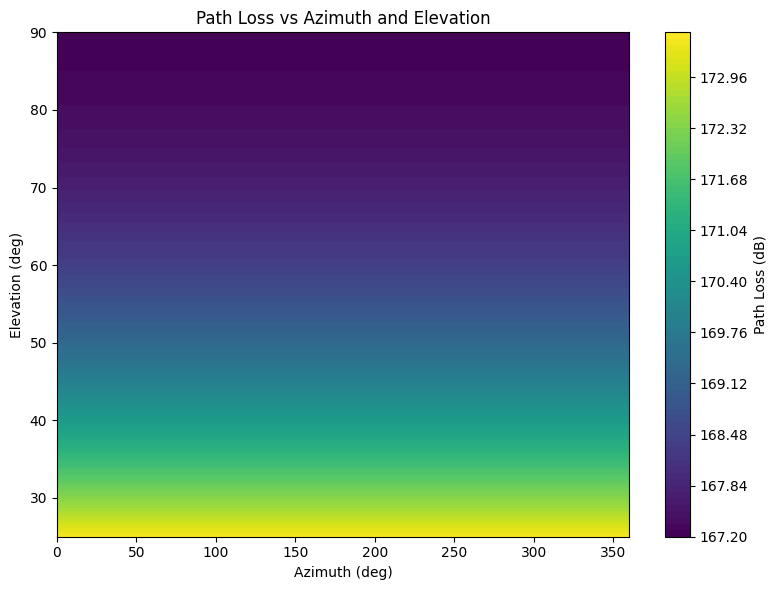

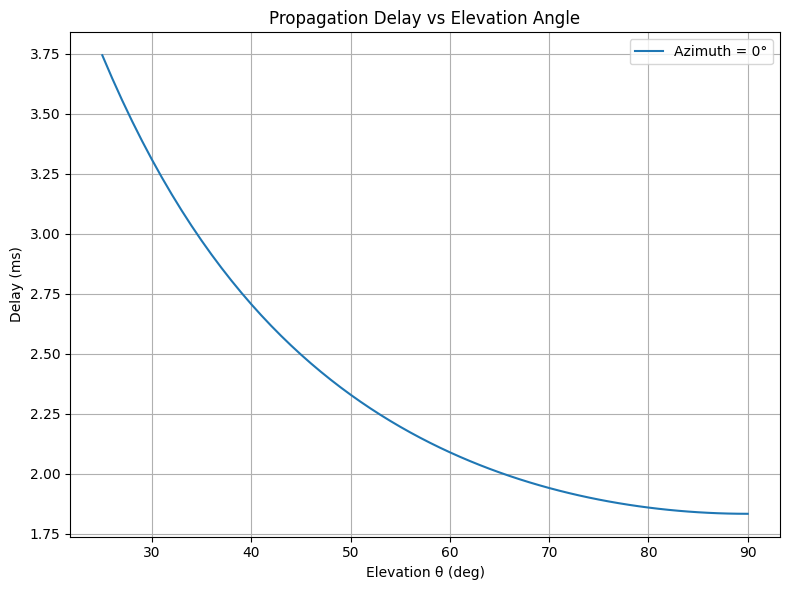

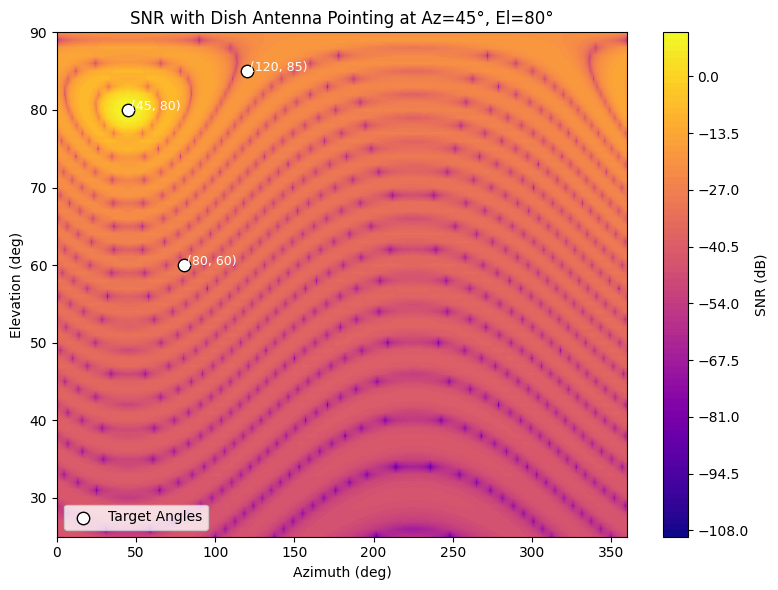

SNR at specified angles:
Azimuth 45°, Elevation 80° → SNR = 9.47 dB
Azimuth 80°, Elevation 60° → SNR = -29.31 dB
Azimuth 120°, Elevation 85° → SNR = -21.52 dB


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# --------------------------
# Constants and Parameters
# --------------------------
c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm = 50  # transmit power in dBm
noise_figure_db = 5  # dB
k = 1.38e-23  # Boltzmann constant
T = 150  # temperature in Kelvin
noise_power_dbm = 10 * np.log10(k * T * bandwidth) + 30 + noise_figure_db

earth_radius_m = 6371e3
leo_altitude_m = 550e3
sat_radius_m = earth_radius_m + leo_altitude_m
origin = np.array([0.0, 0.0, earth_radius_m])  # ground station

# --------------------------
# Angular Grid
# --------------------------
el_range_deg = np.linspace(25, 90, 66)
az_range_deg = np.linspace(0, 360, 361)
EL, AZ = np.meshgrid(el_range_deg, az_range_deg)

# Direction vectors (az/el → unit vectors)
el_rad = np.radians(EL)
az_rad = np.radians(AZ)
x = np.cos(el_rad) * np.cos(az_rad)
y = np.cos(el_rad) * np.sin(az_rad)
z = np.sin(el_rad)
dir_vec = np.stack([x, y, z], axis=-1)  # shape = (az, el, 3)

# --------------------------
# Compute Delay and FSPL
# --------------------------
delays = np.full(EL.shape, np.nan)
fspl_db = np.full(EL.shape, np.nan)

for i in range(EL.shape[0]):
    for j in range(EL.shape[1]):
        d = dir_vec[i, j]
        a = np.dot(d, d)
        b = 2 * np.dot(origin, d)
        c_quad = np.dot(origin, origin) - sat_radius_m**2
        discriminant = b**2 - 4 * a * c_quad

        if discriminant < 0:
            continue
        t1 = (-b - np.sqrt(discriminant)) / (2 * a)
        t2 = (-b + np.sqrt(discriminant)) / (2 * a)
        t = min(t for t in (t1, t2) if t > 0)

        point = origin + t * d
        distance = np.linalg.norm(point - origin)
        delays[i, j] = distance / c
        fspl_db[i, j] = 20 * np.log10(4 * np.pi * distance / wavelength)

# --------------------------
# Plot 1: Path Loss Heatmap
# --------------------------
plt.figure(figsize=(8, 6))
c1 = plt.contourf(AZ, EL, fspl_db, levels=100, cmap='viridis')
plt.colorbar(c1, label='Path Loss (dB)')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Elevation (deg)')
plt.title('Path Loss vs Azimuth and Elevation')
plt.tight_layout()
plt.show()

# --------------------------
# Plot 2: Delay vs Elevation (Az=0° slice)
# --------------------------
theta_deg = EL[0, :]
delay_sec = delays[0, :]
plt.figure(figsize=(8, 6))
plt.plot(theta_deg, delay_sec * 1e3, label="Azimuth = 0°", color='tab:blue')
plt.xlabel("Elevation θ (deg)")
plt.ylabel("Delay (ms)")
plt.title("Propagation Delay vs Elevation Angle")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------
# Compute SNR Heatmap
# --------------------------
antenna = DishAntenna3DPattern(frequency_hz=fc, aperture_radius_lambda=10, tx_gain_dB=35)
beam_azimuth_deg = 45
beam_elevation_deg = 80

gain_db = antenna.gain_db(ray_azimuth_deg=AZ,
                          ray_elevation_deg=EL,
                          azimuth_deg=beam_azimuth_deg,
                          elevation_deg=beam_elevation_deg)

rx_power_dbm = tx_power_dbm + gain_db - fspl_db
snr_db = rx_power_dbm - noise_power_dbm

# --------------------------
# Plot 3: SNR Heatmap with Marker Points
# --------------------------
plt.figure(figsize=(8, 6))
c2 = plt.contourf(AZ, EL, snr_db, levels=100, cmap='plasma')
plt.colorbar(c2, label='SNR (dB)')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Elevation (deg)')
plt.title(f'SNR with Dish Antenna Pointing at Az={beam_azimuth_deg}°, El={beam_elevation_deg}°')

# Add specific angles as points
angles = [
    (45, 80),
    (80, 60),
    (120, 85)
]
az_list, el_list = zip(*angles)
plt.scatter(az_list, el_list, color='white', edgecolor='black', s=80, marker='o', label='Target Angles')

for az, el in angles:
    plt.text(az + 2, el, f'({az}, {el})', fontsize=9, color='white')

plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# --------------------------
# Print SNR values at specified angles
# --------------------------
print("SNR at specified angles:")
for az, el in angles:
    
    az_idx = np.argmin(np.abs(az_range_deg - az))
    el_idx = np.argmin(np.abs(el_range_deg - el))
    snr_val = snr_db[az_idx, el_idx]
    print(f"Azimuth {az}°, Elevation {el}° → SNR = {snr_val:.2f} dB")


In [3]:
rx_power_dbm = gain_db - fspl_db
print(rx_power_dbm)

[[-189.05116548 -185.99364616 -186.23008817 ... -161.69040357
  -215.00110066 -162.78528601]
 [-188.44995222 -185.87519392 -186.54589625 ... -161.32338889
  -196.32460445 -162.78528601]
 [-187.93794236 -185.81015399 -186.92741313 ... -160.98067564
  -189.87028038 -162.78528601]
 ...
 [-190.58662389 -186.40442765 -185.7864967  ... -162.50658646
  -188.76335732 -162.78528601]
 [-189.75664289 -186.16872784 -185.97748878 ... -162.08394433
  -194.413326   -162.78528601]
 [-189.05116548 -185.99364616 -186.23008817 ... -161.69040357
  -215.00110066 -162.78528601]]


jitc_llvm_init(): LLVM API initialization failed ..


Directivity [dB]: 36.0
Gain [dB]: 40.0
Efficiency [%]: 2.54e+02


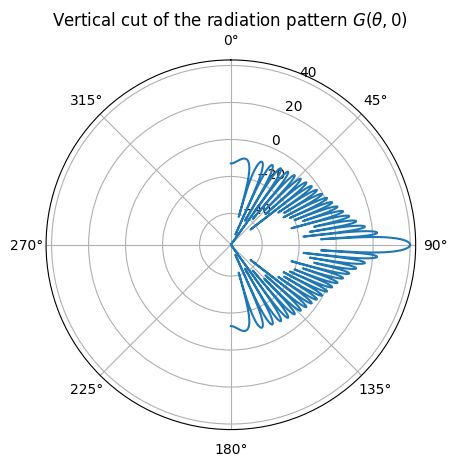

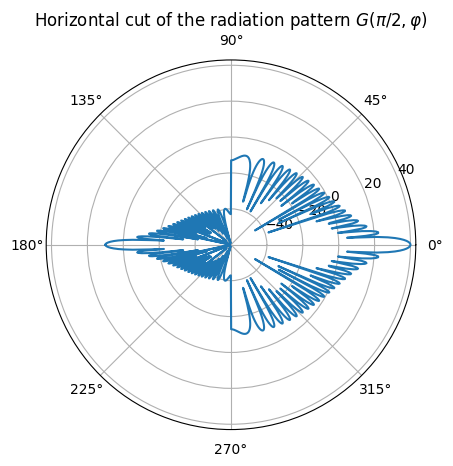

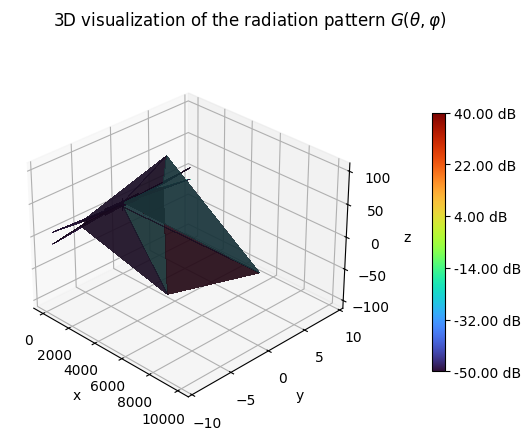

In [4]:
import numpy as np
import drjit as dr
import mitsuba as mi
from scipy.special import jv
from sionna.rt.antenna_pattern import PolarizedAntennaPattern, register_antenna_pattern

def v_vsat_dish_pattern(theta: mi.Float,
                             phi: mi.Float,
                             *,
                             frequency_hz: float = 10e9,
                             aperture_radius_lambda: float = 10.0,
                             g_peak_dBi: float = 40.0,
                             back_supp_db: float = 30.0) -> mi.Complex2f:
    """
    VSAT vertically-polarized antenna pattern based on 3GPP TR 38.811.
    Pattern: (2J1(u)/u)^2, where u = (2πa/λ)·sin(α), α = angle from +x axis.
    """

    # λ and aperture radius a [m]
    c = 3e8
    lam = c / frequency_hz
    a = aperture_radius_lambda * lam

    # Convert input to numpy
    theta_np = theta.numpy() if hasattr(theta, "numpy") else np.array(theta)
    phi_np = phi.numpy() if hasattr(phi, "numpy") else np.array(phi)

    # Compute angle from main beam (x-axis): α = arccos(sinθ·cosφ)
    ray_x = np.sin(theta_np) * np.cos(phi_np)
    alpha = np.arccos(np.clip(ray_x, -1.0, 1.0))

    # Compute u = (2πa/λ)·sin(α)
    u = 2 * np.pi * a * np.sin(alpha) / lam
    u_safe = np.where(np.abs(u) < 1e-10, 1e-10, u)

    # Pattern using Bessel function
    j1_u = jv(1, u_safe)
    pattern = (2 * j1_u / u_safe) ** 2
    pattern = np.where(np.abs(u) < 1e-10, 1.0, pattern)

    # Normalize by peak gain
    max_gain_lin = 10 ** (g_peak_dBi / 10)
    pattern *= max_gain_lin

    # Back lobe suppression
    pattern = np.where(alpha > (np.pi / 2), pattern * 10 ** (-back_supp_db / 10), pattern)

    # Convert to field amplitude
    field_amp = np.sqrt(pattern)
    return mi.Complex2f(mi.Float(field_amp), mi.Float(0.0))

# ---------- Sionna Integration ----------
def _vsat_factory(*, polarization: str,
                  polarization_model: str = "tr38901_2",
                  frequency_hz: float = 10e9):
    return PolarizedAntennaPattern(
        v_pattern=lambda theta, phi: v_vsat_dish_pattern(theta, phi, frequency_hz=frequency_hz),
        polarization=polarization,
        polarization_model=polarization_model
    )

register_antenna_pattern("vsat_dish", _vsat_factory)
from sionna.rt import PlanarArray
# import vsat_dish_3gpp  # Make sure this file is in your PYTHONPATH

array = PlanarArray(num_rows=1, num_cols=1,
                    pattern="vsat_dish", polarization="V")

array.antenna_pattern.show()
d, g, eta = array.antenna_pattern.compute_gain()


In [5]:
from sionna.rt import Scene, Receiver, Transmitter
import numpy as np
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies
scene = Scene()     
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[0,0,0],
                 power_dbm=30,
                 display_radius=200)

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[0,0,550000],
              display_radius=200)

# Add receiver instance to scene
scene.add(rx)

tx.look_at(rx) # Transmitter points towards receiver


scene.synthetic_array = False 
scene.frequency = 10e9

p_solver  = PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=0,
                 los=True,
                #  specular_reflection=True,
                #  diffuse_reflection=False,
                #  refraction=True,
                 synthetic_array=False,
                 seed=41)
a, tau = paths.cir(normalize_delays=False, out_type="numpy")
rx_power_linear = np.sum(np.abs(a)**2)   
rx_power_dbm = 10 * np.log10(rx_power_linear)  
print(f"Received power: {rx_power_dbm:.2f} dB")
import math

def fspl_db(distance_km, freq_ghz):
    return 20 * math.log10(distance_km) + 20 * math.log10(freq_ghz) + 92.45

# 示例：550km，频率10GHz
d = 550
f = 10
fspl = fspl_db(d, f)
print(f"FSPL = {fspl:.2f} dB")


Received power: -167.26 dB
FSPL = 167.26 dB


In [6]:
import numpy as np

def compute_satellite_intersection_point_enu(az_deg, el_deg, sat_orbit_m):
    """
    Given azimuth/elevation angles, compute the intersection point with the satellite shell.
    The origin is defined in the local ENU frame centered at the ground transmitter.

    Args:
        az_deg: Azimuth angle in degrees
        el_deg: Elevation angle in degrees
        sat_orbit_m: Satellite orbit height above Earth's surface in meters

    Returns:
        point_enu: np.array([x, y, z]) in meters (ENU coordinates)
        delay_ms: Propagation delay in milliseconds
        distance_m: Propagation distance in meters
    """
    earth_radius_m = 6371e3
    sat_radius_m = earth_radius_m + sat_orbit_m
    tx_pos = np.array([0, 0, earth_radius_m])  # Ground TX position in ECEF
    c = 3e8  # Speed of light (m/s)

    # Convert angles to radians
    az = np.radians(az_deg)
    el = np.radians(el_deg)

    # Compute ray direction vector
    d = np.array([
        np.cos(el) * np.cos(az),
        np.cos(el) * np.sin(az),
        np.sin(el)
    ])

    # Quadratic coefficients for intersection with sphere
    o = tx_pos
    a = np.dot(d, d)
    b = 2 * np.dot(o, d)
    c_quad = np.dot(o, o) - sat_radius_m**2
    discriminant = b**2 - 4 * a * c_quad

    if discriminant < 0:
        raise ValueError("No intersection with satellite shell")

    t1 = (-b - np.sqrt(discriminant)) / (2 * a)
    t2 = (-b + np.sqrt(discriminant)) / (2 * a)
    t = min(t for t in (t1, t2) if t > 0)

    point_ecef = o + t * d
    point_enu = point_ecef - tx_pos

    distance_m = np.linalg.norm(point_enu)
    delay_ms = distance_m / c * 1e3  # Convert to milliseconds

    return point_enu, delay_ms, distance_m


sat_orbit_m = 550e3  # LEO orbit height

angles = [
    (45, 80),
    (80, 60),
    (120, 85)
]

rx_positions = []
delays_ms = []
fspl_db = []

frequency_hz = 10e9
wavelength = 3e8 / frequency_hz

for az, el in angles:
    pos, delay, dist = compute_satellite_intersection_point_enu(az, el, sat_orbit_m)
    rx_positions.append(pos)
    delays_ms.append(delay)
    fspl = 20 * np.log10(4 * np.pi * dist / wavelength)
    fspl_db.append(fspl)

# -------------------------------
# Output
# -------------------------------
rx_positions = np.array(rx_positions)
delays_ms = np.array(delays_ms)
fspl_db = np.array(fspl_db)

print("Satellite shell intersection points (ENU) [meters]:\n", rx_positions)
print("\nPropagation delays [ms]:\n", delays_ms)
print("\nFree-space path loss [dB]:\n", fspl_db)


Satellite shell intersection points (ENU) [meters]:
 [[ 68490.59014316  68490.59014316 549322.18022569]
 [ 54428.75149271 308680.78880511 542898.66006392]
 [-24052.06951163  41659.40642133 549832.82501527]]

Propagation delays [ms]:
 [1.8593212  2.08961792 1.83977699]

Free-space path loss [dB]:
 [167.37128571 168.38553495 167.27950094]


In [ ]:
from sionna.rt import Scene, Receiver, Transmitter, PlanarArray, PathSolver
import numpy as np
import math

# Create scene
scene = Scene()     

# Antenna pattern
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="vsat_dish",
                             polarization="V")

scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")


for tx_name in scene.transmitters:
    scene.remove(tx_name)
for rx_name in scene.receivers:
    scene.remove(rx_name) 
# TX at origin
tx = Transmitter(name="tx",
                 position=[0, 0, 0],
                 power_dbm=30,
                 display_radius=200)
scene.add(tx)

# Define RX positions (550 km above ground, different Y rows)

# Add RXs to scene
rxs = []
for i, pos in enumerate(rx_positions):
    rx = Receiver(name=f"rx{i}", position=pos, display_radius=200)
    scene.add(rx)
    rx.look_at(tx)
    rxs.append(rx)

# Let TX point at the center RX (rx1)

tx.look_at(rxs[0])

# Simulation settings
scene.synthetic_array = False 
scene.frequency = 10e9

# Run propagation solver
p_solver  = PathSolver()
paths = p_solver(scene=scene,
                 max_depth=0,
                 los=True,
                 synthetic_array=False,
                 seed=41)

# CIR analysis
a, tau = paths.cir(normalize_delays=False, out_type="numpy")
rx_power_linear = np.sum(np.abs(a)**2)   
rx_power_dbm = 10 * np.log10(rx_power_linear)  
print(f"Total received power (sum over all RXs): {rx_power_dbm:.2f} dB")

# FSPL reference calculation
def fspl_db(distance_km, freq_ghz):
    return 20 * math.log10(distance_km) + 20 * math.log10(freq_ghz) + 92.45

fspl = fspl_db(550, 10)
print(f"FSPL (free space, 550km @ 10GHz) = {fspl:.2f} dB")

c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm = 50  # transmit power in dBm
noise_figure_db = 5  # dB
k = 1.38e-23  # Boltzmann constant
T = 150  # temperature in Kelvin
noise_power_dbm = 10 * np.log10(k * T * bandwidth) + 30 + noise_figure_db

Tx_power_watt = 10 ** (tx_power_dbm / 10) / 1000  # dBm → Watt
N0_watt = 10 ** (noise_power_dbm / 10) / 1000     # dBm → Watt

# Remove singleton dims: (3, 1, 1, 1, 1, 1) → (3,)
a_squeezed = np.squeeze(a)


snr_linear = (np.abs(a_squeezed) ** 2) * Tx_power_watt / N0_watt
snr_db = 10 * np.log10(snr_linear)

for i, snr_val in enumerate(snr_db):
    print(f"SNR at Rx{i}: {snr_val:.2f} dB")


Total received power (sum over all RXs): -127.38 dB
FSPL (free space, 550km @ 10GHz) = 167.26 dB
SNR at Rx0: 14.46 dB
SNR at Rx1: -26.13 dB
SNR at Rx2: -27.83 dB


In [8]:
10 * np.log10((np.abs(a_squeezed) ** 2))

array([-127.377304, -167.96857 , -169.67055 ], dtype=float32)

In [9]:
print(tau*1000)

[[[[[1.8606083]]]]



 [[[[2.0910647]]]]



 [[[[1.8410507]]]]]
